In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Leemos datos del csv.

In [2]:
data = pd.read_csv('phishing.csv')

Chequeamos si hay valores nulos. 

In [3]:
nulos = pd.isnull(data).sum()
print(nulos)

Index                  0
UsingIP                0
LongURL                0
ShortURL               0
Symbol@                0
Redirecting//          0
PrefixSuffix-          0
SubDomains             0
HTTPS                  0
DomainRegLen           0
Favicon                0
NonStdPort             0
HTTPSDomainURL         0
RequestURL             0
AnchorURL              0
LinksInScriptTags      0
ServerFormHandler      0
InfoEmail              0
AbnormalURL            0
WebsiteForwarding      0
StatusBarCust          0
DisableRightClick      0
UsingPopupWindow       0
IframeRedirection      0
AgeofDomain            0
DNSRecording           0
WebsiteTraffic         0
PageRank               0
GoogleIndex            0
LinksPointingToPage    0
StatsReport            0
class                  0
dtype: int64


Separamos en data y target.

In [4]:
X = np.array(data[data.columns[0:(len(data.columns) - 1)]])
print(X.shape)
y = pd.factorize(data['class'].values)[0]

(11054, 31)


Saco la primer variable de X: index.

In [5]:
numbers = list(range(1,32))
X = X[:,list(range(1,31))]
print(X.shape)
columns = []
for number in numbers:
    columns.append(data.columns[number])

(11054, 30)


Hold-out. Para separar datos de train y test utilizamos el metodo hold-out con un 80% de ejemplos para el train.

Fijamos semilla para que sea reproducible. 

In [6]:
from sklearn import tree, model_selection, metrics

np.random.seed(12)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.8)

Probaremos resolver el problema con: KNN, árbol de decisión y Random Forest. Además, para cada uno cambiaremos su configuración. 

Comenzamos con arbol de decisión. Vemos sus porcentajes de aciertos segun el tipo de arbol. 

In [7]:
listaAccTrain = []
listaAccTest = []


for tipoArbol in ['gini','entropy']:
    clasificador = tree.DecisionTreeClassifier(criterion=tipoArbol)
    clasificador.fit(X_train,y_train)

    prediccionesTrain = clasificador.predict(X_train)
    aciertoTrain = metrics.accuracy_score(prediccionesTrain, y_train) * 100
    prediccionesTest = clasificador.predict(X_test)
    aciertoTest = metrics.accuracy_score(prediccionesTest, y_test) * 100
    
    listaAccTrain.append(aciertoTrain)
    listaAccTest.append(aciertoTest)
    
print(listaAccTrain)
print(listaAccTest)

[99.07271288024427, 99.07271288024427]
[96.11035730438715, 96.47218453188603]


Buscamos la mejor configuración de los árboles de decisión utilizando una validación cruzada de 10 particiones.

In [8]:
semilla = np.random.seed(12)

c = tree.DecisionTreeClassifier()

params = {
    'criterion': ['gini', 'entropy'], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
}

clasificadores =  model_selection.GridSearchCV(c, params, scoring='accuracy', cv=10, return_train_score=True, iid=True)
clasificadores.fit(X_train,y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid=True, n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 2, 4],
                      

In [9]:
print(clasificadores.best_score_)
print(clasificadores.best_params_)

0.9624561800294018
{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2}


Probamos con random forest para comparar rendimientos

In [10]:
from sklearn.ensemble import RandomForestClassifier

for tipoArbol in ['gini','entropy']:
    clfRF = RandomForestClassifier(criterion=tipoArbol,
                                 n_estimators=100, random_state=0)
    clfRF.fit(X_train,y_train)
    predTrain = clfRF.predict(X_train)
    predTest = clfRF.predict(X_test)
    accTrainRF = metrics.accuracy_score(predTrain, y_train) * 100
    accTestRF =  metrics.accuracy_score(predTest, y_test) * 100
    print(accTrainRF)
    print(accTestRF)

99.07271288024427
96.8340117593849
99.07271288024427
96.87924016282226


Buscamos su mejor configuracion con gridSearchCV. Ojo: demora 10 minutos aprox.

In [11]:
semilla = np.random.seed(12)
clasificador = RandomForestClassifier()

params = {'n_estimators': [10,50,100], 
          'max_features': [1,'sqrt','log2',None], 
          'criterion': ['gini','entropy'],
          'max_depth': [5,10,None],
          'min_samples_split': [2,10,20]
         }

clasificadoresRF =  model_selection.GridSearchCV(clasificador, params, scoring='accuracy', cv=10, return_train_score=True, iid=True)
clasificadoresRF.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [12]:
print(clasificadoresRF.best_score_)
print(clasificadoresRF.best_params_)

0.9731991405631573
{'criterion': 'entropy', 'max_depth': None, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 100}


Entreno con la mejor configuracion:

In [13]:
clfRF = RandomForestClassifier(criterion= clasificadoresRF.best_params_['criterion'],
                             max_depth= clasificadoresRF.best_params_['max_depth'],
                              max_features= clasificadoresRF.best_params_['max_features'],
                              min_samples_split= clasificadoresRF.best_params_['min_samples_split'],
                              n_estimators= clasificadoresRF.best_params_['n_estimators'])
clfRF.fit(X_train,y_train)
predTrain = clfRF.predict(X_train)
predTest = clfRF.predict(X_test)
accTrainRF = metrics.accuracy_score(predTrain, y_train) * 100
accTestRF =  metrics.accuracy_score(predTest, y_test) * 100

print(accTrainRF)
print(accTestRF)

99.07271288024427
96.96969696969697


A continuacion buscaremos las variables mas importantes. Tanto con el arbol como con el random forest. 

Arbol: Busco variables mas importantes con SelectFromModel.

In [14]:
from sklearn.feature_selection import SelectFromModel

arbolDecision = tree.DecisionTreeClassifier(criterion=clasificadores.best_params_['criterion']
                                            , min_samples_split=clasificadores.best_params_['min_samples_split']
                                            , min_samples_leaf=clasificadores.best_params_['min_samples_leaf'])
model =  SelectFromModel(arbolDecision, threshold='median')
model.fit(X_train,y_train)

X_new =  model.transform(X_train)
booleanas =  model.get_support()

variablesSeleccionadas = [columns[i] for i in range(len(columns) - 1) if booleanas[i]==True]
print("Las variables seleccionadas son ", variablesSeleccionadas)

indicesSeleccionados = [i for i in range(len(columns) - 1) if booleanas[i]==True]

variablesDescartadas = [columns[i] for i in range(len(columns) - 1) if booleanas[i]==False]
print("Las variables descartadas son ", variablesDescartadas)

Las variables seleccionadas son  ['UsingIP', 'PrefixSuffix-', 'SubDomains', 'HTTPS', 'DomainRegLen', 'RequestURL', 'AnchorURL', 'LinksInScriptTags', 'ServerFormHandler', 'AgeofDomain', 'DNSRecording', 'WebsiteTraffic', 'PageRank', 'GoogleIndex', 'LinksPointingToPage']
Las variables descartadas son  ['LongURL', 'ShortURL', 'Symbol@', 'Redirecting//', 'Favicon', 'NonStdPort', 'HTTPSDomainURL', 'InfoEmail', 'AbnormalURL', 'WebsiteForwarding', 'StatusBarCust', 'DisableRightClick', 'UsingPopupWindow', 'IframeRedirection', 'StatsReport']


Entrenamos el arbol solo con las varables seleccionadas

In [15]:
arbolDecision = tree.DecisionTreeClassifier(criterion=clasificadores.best_params_['criterion']
                                            , min_samples_split=clasificadores.best_params_['min_samples_split']
                                            , min_samples_leaf=clasificadores.best_params_['min_samples_leaf'])
arbolDecision.fit(X_new,y_train)

prediccionesTrain = arbolDecision.predict(X_new)

accuracyTrain = metrics.accuracy_score(prediccionesTrain, y_train) * 100
print(accuracyTrain)

prediccionesTest = arbolDecision.predict(X_test[:,indicesSeleccionados])
accuracyTest = metrics.accuracy_score(prediccionesTest, y_test) * 100
print(accuracyTest)

98.49598552527424
95.47715965626413


Perdemos un 1% de rendimiento en test pero utilizamos 15 variables menos. Todavia podemos simplificar mas el arbol. Aumentando el valor de min_samples_split y min_samples_leaf. Veamos que tanto impacta en el rendimiento.

In [16]:
configuraciones = [ [2,2], [2,4], [5,1], [5,2], [5,4], [10,1], [10,2], [10,4] ]

for config in configuraciones:
    print("Split: ", config[0])
    print("Leaf: ", config[1])
    arbolDecision = tree.DecisionTreeClassifier(criterion=clasificadores.best_params_['criterion']
                                                , min_samples_split=config[0]
                                                , min_samples_leaf=config[1])
    arbolDecision.fit(X_new,y_train)

    prediccionesTrain = arbolDecision.predict(X_new)

    accuracyTrain = metrics.accuracy_score(prediccionesTrain, y_train) * 100
    print(accuracyTrain)

    prediccionesTest = arbolDecision.predict(X_test[:,indicesSeleccionados])
    accuracyTest = metrics.accuracy_score(prediccionesTest, y_test) * 100
    print(accuracyTest)
    
    print("----------------")

Split:  2
Leaf:  2
97.63654868257379
94.48213478064224
----------------
Split:  2
Leaf:  4
96.77711183987334
94.39167797376753
----------------
Split:  5
Leaf:  1
98.02103358588714
94.88919041157847
----------------
Split:  5
Leaf:  2
97.56869840551849
94.5273631840796
----------------
Split:  5
Leaf:  4
96.79972859889178
94.34644957033017
----------------
Split:  10
Leaf:  1
97.30860567680651
94.43690637720489
----------------
Split:  10
Leaf:  2
97.12767160465904
94.39167797376753
----------------
Split:  10
Leaf:  4
96.70926156281806
94.34644957033017
----------------


RandomForest:

La importancia de la variable HTTPS es: 21.61126
La importancia de la variable AnchorURL es: 20.13312
La importancia de la variable WebsiteTraffic es: 7.74217
La importancia de la variable SubDomains es: 7.01407
La importancia de la variable LinksInScriptTags es: 6.03702
La importancia de la variable PrefixSuffix- es: 4.89121
La importancia de la variable ServerFormHandler es: 3.3985
La importancia de la variable LinksPointingToPage es: 2.99325
La importancia de la variable RequestURL es: 2.72153
La importancia de la variable AgeofDomain es: 2.28849
La importancia de la variable DomainRegLen es: 2.2672
La importancia de la variable UsingIP es: 2.23598
La importancia de la variable DNSRecording es: 1.8495
La importancia de la variable PageRank es: 1.84617
La importancia de la variable GoogleIndex es: 1.81279
La importancia de la variable LongURL es: 1.35139
La importancia de la variable StatsReport es: 0.98212
La importancia de la variable Symbol@ es: 0.91564
La importancia de la variab

<BarContainer object of 30 artists>

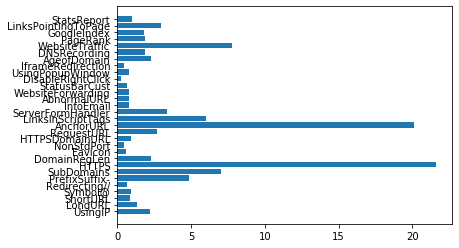

In [17]:
importancias = clfRF.feature_importances_ * 100

variables_importancia = [(nombreVar, round(importancia, 5)) for nombreVar, importancia in 
                         zip(columns, importancias)]

variables_importancia_ordenado = sorted(variables_importancia, key = lambda x: x[1], reverse = True)

for nomVar, imp in variables_importancia_ordenado:
    print("La importancia de la variable {} es: {}".format(nomVar, imp))

plt.barh(np.array(variables_importancia)[:,0], importancias)

Como podemos vee las primeras 15 variables son  las mismas que las que elige el arbol. 

Entreno el random forest solo con las variables seleccionadas

In [18]:
clfRF = RandomForestClassifier(criterion= clasificadoresRF.best_params_['criterion'],
                             max_depth= clasificadoresRF.best_params_['max_depth'],
                              max_features= clasificadoresRF.best_params_['max_features'],
                              min_samples_split= clasificadoresRF.best_params_['min_samples_split'],
                              n_estimators= clasificadoresRF.best_params_['n_estimators'])
clfRF.fit(X_new,y_train)
predTrain = clfRF.predict(X_new)
predTest = clfRF.predict(X_test[:,indicesSeleccionados])
accTrainRF = metrics.accuracy_score(predTrain, y_train) * 100
accTestRF =  metrics.accuracy_score(predTest, y_test) * 100

print(accTrainRF)
print(accTestRF)

98.49598552527424
96.51741293532339


La diferencia de rendimiento es baja por lo tanto nos quedamos con el arbol de decision por su simplicidad.

KNN:

In [19]:
from sklearn import neighbors

accTrain = []
accTest = []
for k in [1,3,5,7]:
    print (k)
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    
    predicciones_train = knn.predict(X_train)
    accuracy_train = metrics.accuracy_score(y_train, predicciones_train)
    accTrain.append(accuracy_train)
    print (accuracy_train)
    
    predicciones_test = knn.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, predicciones_test)
    accTest.append(accuracy_test)
    print (accuracy_test)
    print("-----------")
    


1
0.9873346149496777
0.9615558570782451
-----------
3
0.9752346488748163
0.9430122116689281
-----------
5
0.9646047721361529
0.937584803256445
-----------
7
0.9590636661766369
0.9380370872908186
-----------


Buscamos la mejor configuracion. Ojo: demora 5 minutos aprox.

In [20]:
semilla = np.random.seed(12)
knn = neighbors.KNeighborsClassifier()

params = {'n_neighbors': [1,3,5,7], 
          'metric': ['manhattan','euclidean'], 
          'weights': ['uniform','distance'],
         }

clasificadoresKNN =  model_selection.GridSearchCV(knn, params, scoring='accuracy', cv=10, return_train_score=True, iid=True)
clasificadoresKNN.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=None,
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': [1, 3, 5, 7],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [21]:
print(clasificadoresKNN.best_score_)
print(clasificadoresKNN.best_params_)

0.9643786045459686
{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


Entrenamos con la mejor configuracion de KNN

In [22]:
knn = neighbors.KNeighborsClassifier(n_neighbors= clasificadoresKNN.best_params_['n_neighbors'],
                                    weights= clasificadoresKNN.best_params_['weights'],
                                    metric= clasificadoresKNN.best_params_['metric'])
knn.fit(X_train,y_train)

predicciones_train = knn.predict(X_train)
accuracy_train = metrics.accuracy_score(y_train, predicciones_train)
accTrain.append(accuracy_train)
print (accuracy_train)

predicciones_test = knn.predict(X_test)
accuracy_test = metrics.accuracy_score(y_test, predicciones_test)
accTest.append(accuracy_test)
print (accuracy_test)

0.9907271288024426
0.9624604251469923
